# Run CalicoST on a simulated data

## Download the data

We applied CalicoST on a small simulated data provided by the [google drive](https://drive.google.com/file/d/1en4vxdwoXt4j51vj8SyRdsszcPSyAErP/view?usp=sharing).

After downloading and untarring file, you will see the following files/directories

- CalicoST_example
    - example_config.yaml: the parameters and paths to run CalicoST
    - GRCh38_resources: reference annotation information
    - outs: simulated transcript count matrix and spatial coordinates
    - snpinfo: parsed allele count matrix

## Take a look at the parameter setting of CalicoST in `example_config.yaml`

On this simulated data, we assume each spot contain a homogeneous clone by setting an empty tumor proportion file in `example_config.yaml`:
```
tumorprop_file: None
```

Note that since the allele count matrix has been provided, we directly provide the directory in `example_config.yaml` by
```
output_snpinfo: "snpinfo"
```
and don't need to run the SNP preprocessing step again.

The `example_config.yaml` file also specifies CalicoST output directory by
```
outputdir_calicost: "calicost"
```

Other important CalicoST parameters are also specified in the `example_config.yaml` file:
- The directory of the transcript count matrix is specified by `spaceranger_dir: "outs"`
- The seed of random initializations of CalicoST HMRF is specified by `random_state: [0, 1, 2, 3, 4]`. This configuration indicates we will run CalicoST five times.
- The number of clones to initialize when considering BAF signals only is specified by `n_clones: 3`. Note that the final number of clones will not be this number, but instead the number of refined clones considering both expression and BAF signals that cannot be merged after comparing the pairwise CNA similarity among clones.
- The number of copy number states to infer using HMM is specified by `n_states: 7`.
- The self-transition probability of copy number states is specified by `t: "1-1e-5"`.
- The strength of spatial coherence is specified by `spatial_weight: 1.0`, the higher the value, the more spatial coherence of the inferred clones will be.
- The threshold of Neyman Pearson statistics to determine whether two clones should be merged based on CNA similarity is specified by `np_threshold: 1.0`. The higher the value, the more likely two clones will be merged.

## Run CalicoST to infer CNAs and cancer clones under the homogeneous clone assumption

To run CalicoST, we first add the path to CalicoST code directory in `example_config.yaml` file in the following entry:
```
calicost_dir: <path to CalicoST code directory>
```

Now we run CalicoST using snakemake by running the following command in shell.
```
cd CalicoST_example
snakemake --cores <number cores> --configfile example_config.yaml --snakefile <CalicoST code directory>/calicost.smk
```

It takes about 1h to run on this simulated data using five cores. When finished, the CalicoST output directory `calicost` will be created with the following main output results corresponding to each random initialization:
- `calicost/<random initialization>/clone_labels.tsv` store the inferred cancer clones;
- `calicost/<random initialization>/cnv_seglevel.tsv` store the inferred allele-specific copy number profile per genomic segment;
- `calicost/<random initialization>/cnv_genelevel.tsv` store the inferred allele-specific copy numbers projected to expressed genes;
- `calicost/<random initialization>/cnv_diploid*`, `calicost/<random initialization>/cnv_triploid*`, `calicost/<random initialization>/cnv_tetraploid*` store an additional version of integer allele-specific copy numbers when enforcing the ploidy to be diploid, triploid, and tetraploid. Experienced users can decide which ploidy to use based on prior knowledge or based on the rdr-baf plots.

## Load the results corresponding to the best initialization

Remember we run CalicoST using five different random seeds specified by `random_state`, now we select the random seed corresponding to the highest log-likelihood under CalicoST's probabilistic model using the following function

In [1]:
import numpy as np
import pandas as pd
import calicost.utils_IO

calicost_example_dir = "."
dir_best_initialization = calicost.utils_IO.get_best_initialization(f'{calicost_example_dir}/calicost')

dir_best_initialization

'calicost/clone3_rectangle3_w1.0'

In [2]:
df_clones = pd.read_csv(f"{dir_best_initialization}/clone_labels.tsv", header=0, index_col=0, sep='\t')
df_clones

,clone_label
BARCODES,
spot_0,2
spot_1,2
spot_2,2
spot_3,2
spot_4,2
...,...
spot_1795,1
spot_1796,1
spot_1797,1


In [3]:
df_cna = pd.read_csv(f"{dir_best_initialization}/cnv_genelevel.tsv", header=0, index_col=0, sep='\t')
df_cna

,clone0 A,clone0 B,clone1 A,clone1 B,clone2 A,clone2 B
gene,,,,,,
A1BG,1,1,1,1,1,1
A1CF,1,1,1,1,1,1
A2M,1,1,1,1,1,1
A2ML1-AS1,1,1,1,1,1,1
AACS,1,1,1,1,1,1
...,...,...,...,...,...,...
ZWILCH,1,1,1,1,1,1
ZXDC,1,1,1,1,1,1
ZYG11B,1,1,1,1,1,1


CalicoST also generates plots of 
- the spatial localization of the inferred clones in `calicost/<random initialization>/plots/clone_spatial.pdf`;
- allele-specific copy numbers along the genome per clone in `calicost/<random initialization>/plots/acn_genome.pdf`, which is under the same color scheme as Fig2c;
- RDR-BAF along the genome for each clone in `calicost/<random initialization>/plots/rdr_baf_defaultcolor.pdf`.

We load the plots in this notebook as follows.

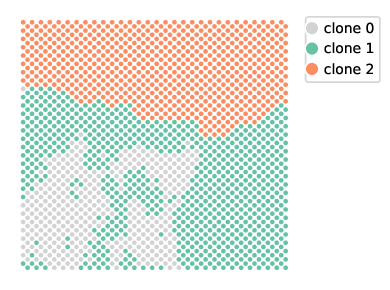

In [4]:
from wand.image import Image as WImage
img = WImage(filename=f"{dir_best_initialization}/plots/clone_spatial.pdf", resolution=100)
img

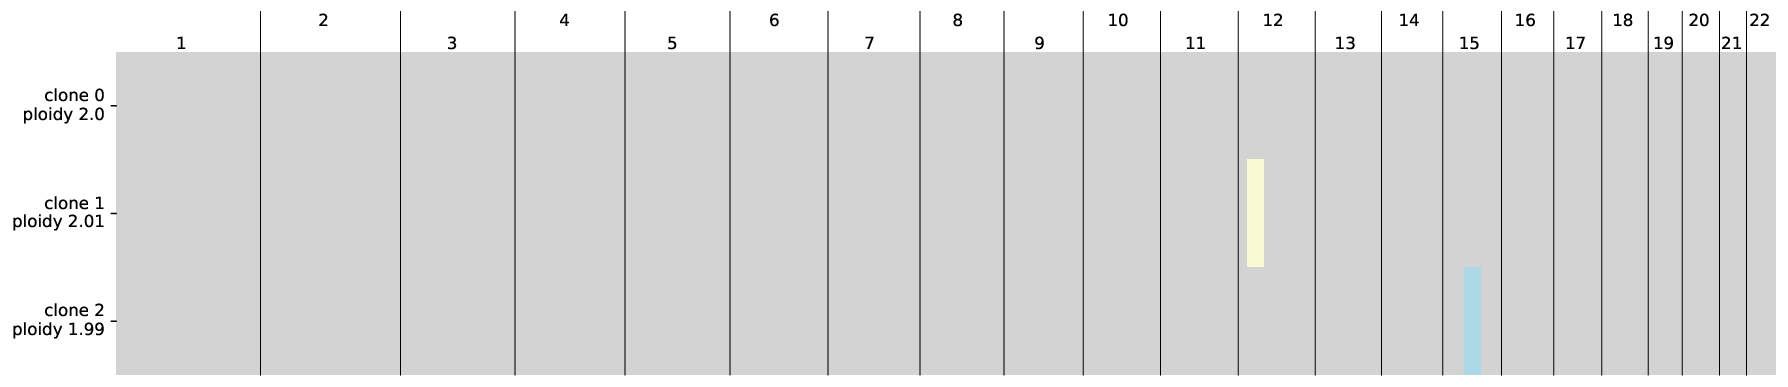

In [5]:
# allele-specific copy numbers of each clone (the color scheme is the same as Fig2c
img = WImage(filename=f"{dir_best_initialization}/plots/acn_genome.pdf", resolution=120)
img

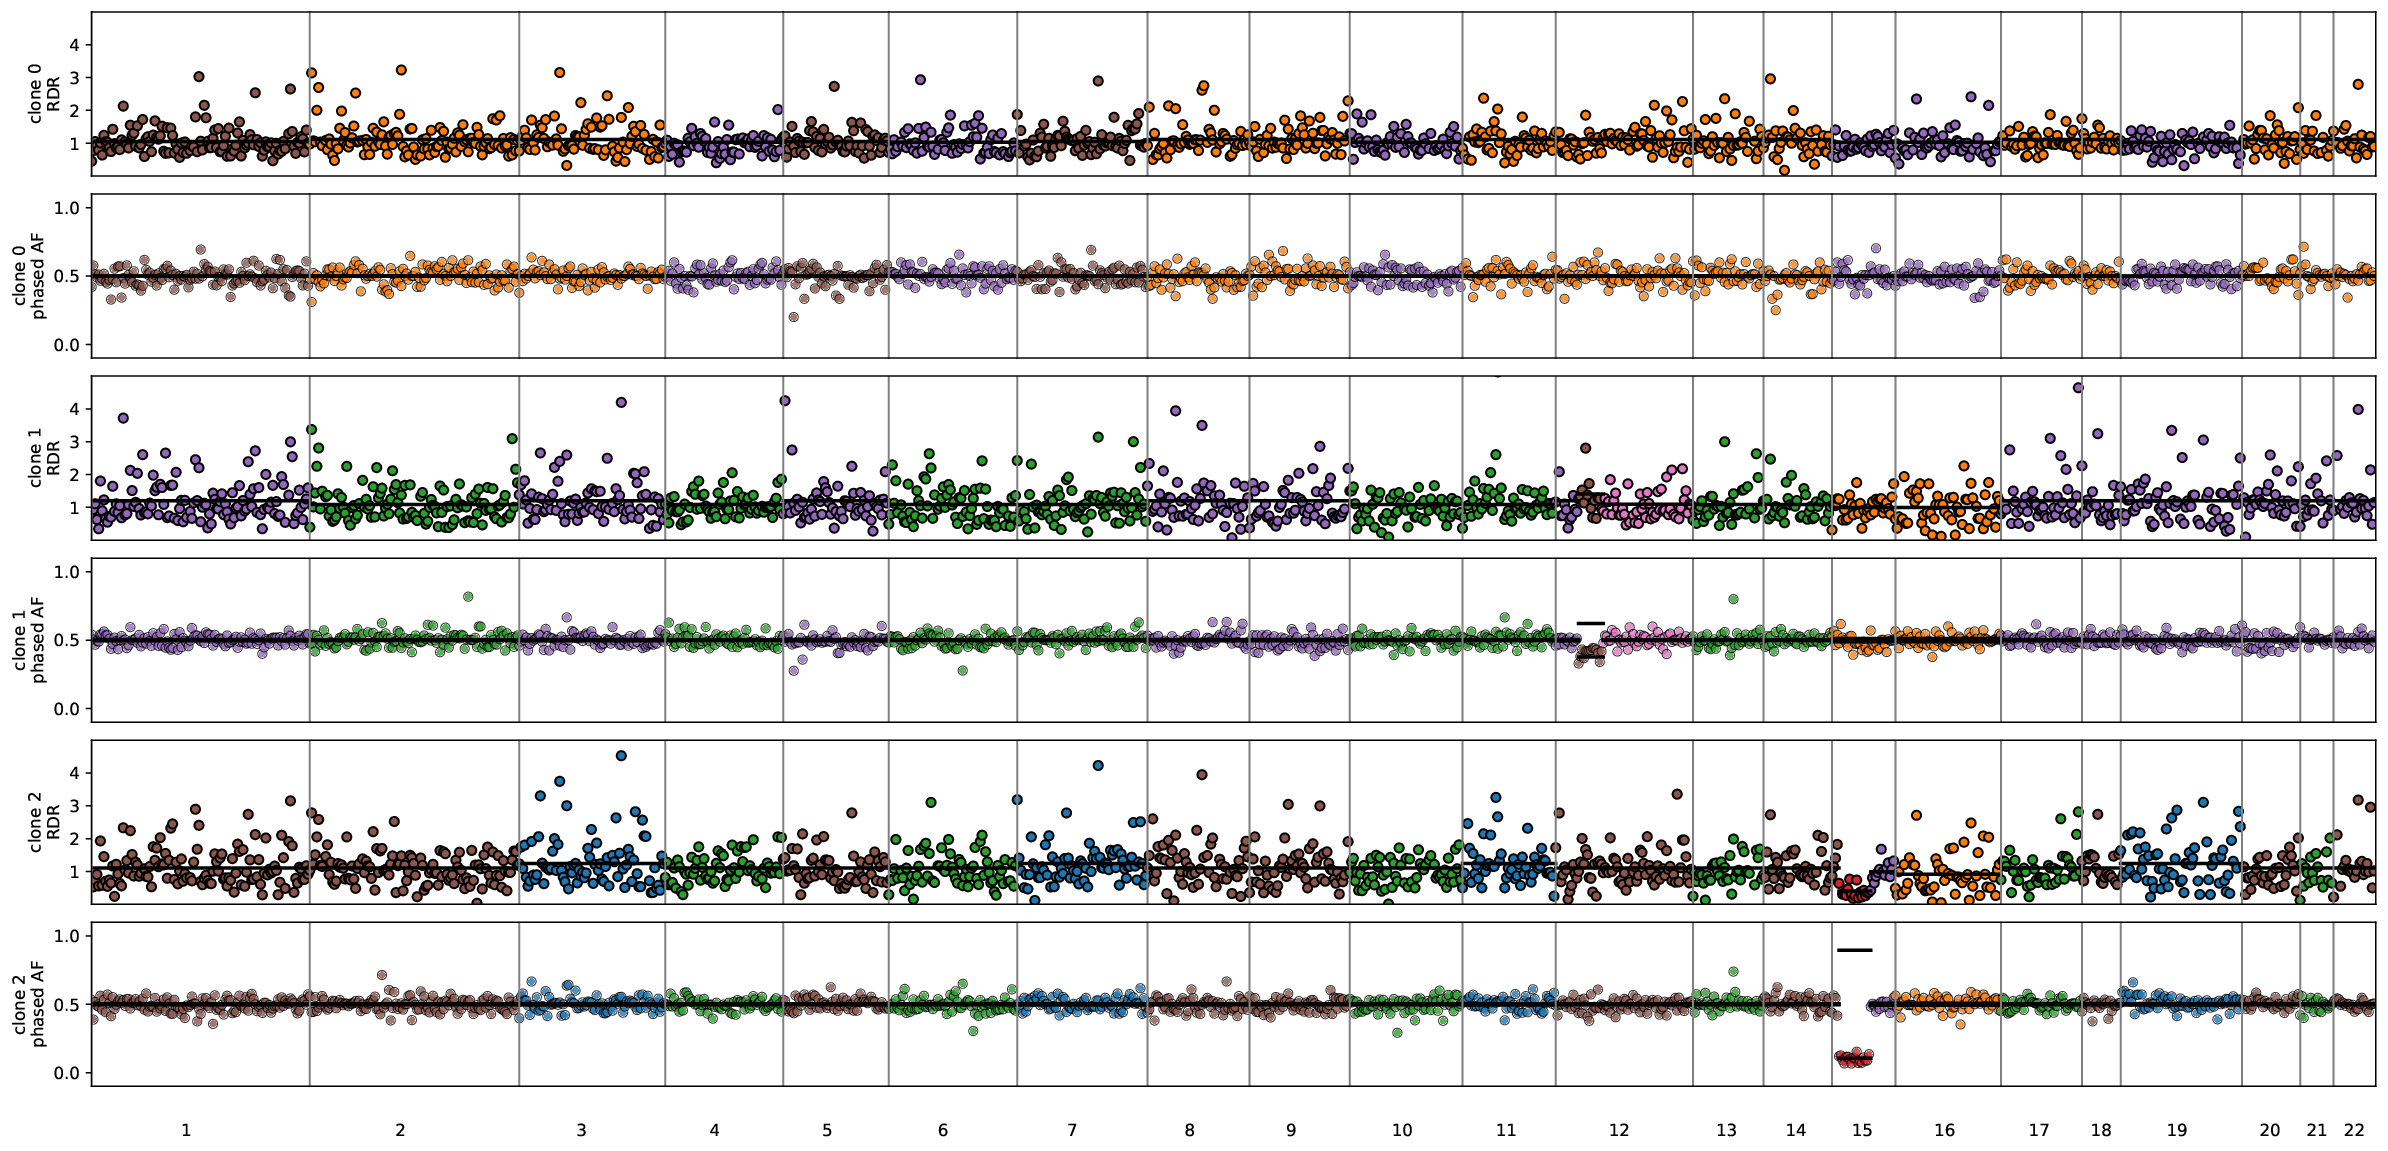

In [6]:
# RDR-BAF plot along the genome for each clone
img = WImage(filename=f"{dir_best_initialization}/plots/rdr_baf_defaultcolor.pdf", resolution=120)
img
